In [6]:
# 📦 Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Chargement des fichiers CSV (chemins nettoyés)
df_facture = pd.read_csv("C:/Users/User/Downloads/factures_fact.csv", sep=',')
df_admission = pd.read_csv("C:/Users/User/Downloads/admission_fact.csv", sep=',')
df_patient = pd.read_csv("C:/Users/User/Downloads/dim_patient.csv", sep=',')
df_cout = pd.read_csv("C:/Users/User/Downloads/dim_cout.csv", sep=',')

# 👀 Affichage des premières lignes
print("🧾 FACTURE")
display(df_facture.head())

print("\n🏥 ADMISSION")
display(df_admission.head())

print("\n🧑‍⚕️ PATIENT")
display(df_patient.head())

print("\n💸 TYPE DE COUT")
display(df_cout.head())

🧾 FACTURE


,patient_id,length_of_stay,facility_cost,procedure_cost,medication_cost,lab_test_cost,total_cost,subject_id,hadm_id
0,10006,8,8000,10500,21600,196300,236400,10006,142345
1,10011,13,13000,3000,0,70000,86000,10011,105331
2,10013,2,2000,1500,3600,14800,21900,10013,165520
3,10017,8,8000,3000,42000,47700,100700,10017,199207
4,10019,0,0,6000,0,28700,34700,10019,177759



🏥 ADMISSION


,subject_id,hadm_id,hospital_expire_flag,admission_count,procedure_count,los,Time_key
0,10006,142345,0,NaN,NaN,39.18,5032094
1,10006,142345,0,NaN,NaN,172.89,5032094
2,10006,142345,0,NaN,NaN,NaN,5032094
3,10011,105331,1,NaN,NaN,332.42,5062090
4,10011,105331,1,NaN,NaN,NaN,5062090



🧑‍⚕️ PATIENT


,subject_id,dob,gender,insurance,language,religion,marital_status,ethnicity
0,10006,2094-03-05 00:00:00,F,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE
1,10011,2090-06-05 00:00:00,F,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE
2,10013,2038-09-03 00:00:00,F,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE
3,10017,2075-09-21 00:00:00,F,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE
4,10019,2114-06-20 00:00:00,M,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE



💸 TYPE DE COUT


,drug,drug_type,dose_val_rx,dose_unit_rx,amount,cost_id
0,Pneumococcal Vac Polyvalent,MAIN,0.5,mL,400.0,1
1,Pneumococcal Vac Polyvalent,MAIN,0.5,mL,NaN,3
2,Pneumococcal Vac Polyvalent,MAIN,0.5,mL,200.0,5
3,Pneumococcal Vac Polyvalent,MAIN,0.5,mL,30.0,7
4,Pneumococcal Vac Polyvalent,MAIN,0.5,mL,NaN,9



--- Résultats Gradient Boosting ---
Mean Squared Error (MSE) : 539352410415.04
R² Score : 0.36


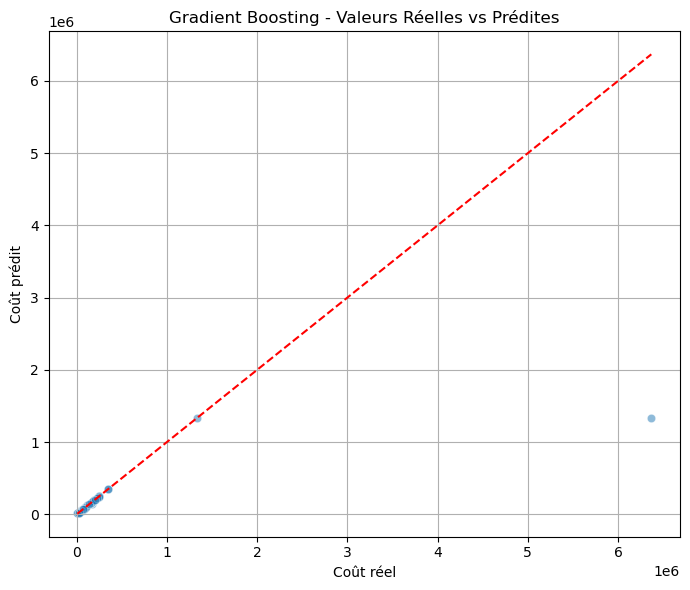


✅ Modèle, scaler et imputer sauvegardés avec succès !


In [7]:
# 🎯 Objectif : Prédire le coût futur d’un patient (Régression)

# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# 🔄 Fusion des données
df = pd.merge(df_facture, df_admission, on=['hadm_id', 'subject_id'], how='left')
df = pd.merge(df, df_patient, on='subject_id', how='left')

# 🧮 Calcul de l'âge
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['age'] = pd.to_datetime('today').year - df['dob'].dt.year

# 🧼 Colonnes manquantes
for col in ['procedure_count', 'admission_count']:
    if col not in df.columns or df[col].isna().all():
        df[col] = 0

# 🔁 Encodage des variables catégorielles
for col in ['gender', 'insurance', 'marital_status']:
    df[col] = df[col].astype(str).fillna('Unknown')
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])

# 🎯 Sélection des features
features = ['procedure_cost', 'medication_cost', 'lab_test_cost', 'age']
X = df[features]
y = df['total_cost']

# 📊 Split d'abord
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧽 Fit Imputer et StandardScaler uniquement sur TRAIN
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# 📈 Entraîner Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train_scaled, y_train)

# 📈 Prédictions
y_pred_gb = gb.predict(X_test_scaled)

# 📊 Évaluation
mse = mean_squared_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)

print("\n--- Résultats Gradient Boosting ---")
print(f"Mean Squared Error (MSE) : {mse:.2f}")
print(f"R² Score : {r2:.2f}")

# 🔥 Visualiser vrai vs prédit
def plot_true_vs_pred(y_true, y_pred, model_name):
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
    plt.xlabel('Coût réel')
    plt.ylabel('Coût prédit')
    plt.title(f'{model_name} - Valeurs Réelles vs Prédites')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_true_vs_pred(y_test, y_pred_gb, "Gradient Boosting")

# 💾 Sauvegarder scaler, imputer, modèle
save_dir = '.'

with open(os.path.join(save_dir, 'imputer_regression.pkl'), 'wb') as f:
    pickle.dump(imputer, f)

with open(os.path.join(save_dir, 'scaler_regression.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

with open(os.path.join(save_dir, 'gb_model.pkl'), 'wb') as f:
    pickle.dump(gb, f)

print("\n✅ Modèle, scaler et imputer sauvegardés avec succès !")


In [8]:
import os
print(os.getcwd())


C:\Users\User\data
